In [15]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, savgol_filter
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft
import umap
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Visualising the data

In [4]:
df = pd.read_csv('data1.txt')
df

,#dateTimeEvent\tspeed\tacceleration\tjerk
0,2024-09-01 10:41:10\t13.0\t0.0\t0.0
1,2024-09-01 10:41:15\t25.4\t0.6888888888888888\...
2,2024-09-01 10:41:20\t36.333333333333336\t0.607...
3,2024-09-01 10:41:25\t21.8\t-0.8074074074074076...
4,2024-09-01 10:41:30\t12.4\t-0.5222222222222223...
...,...
633650,2024-10-08 02:45:20\t0.0\t0.0\t0.0
633651,2024-10-08 02:45:25\t0.0\t0.0\t0.0
633652,2024-10-08 02:45:30\t0.0\t0.0\t0.0
633653,2024-10-08 02:45:35\t0.0\t0.0\t0.0


In [7]:
df = pd.read_csv('data1.txt', sep='\t')
# Split 'dateTimeEvent' into 'date' and 'TimeEvent'
df['dateTimeEvent'] = pd.to_datetime(df['#dateTimeEvent'])
df['date'] = df['dateTimeEvent'].dt.date
df['TimeEvent'] = (df['dateTimeEvent'] - df['dateTimeEvent'].iloc[0]).dt.total_seconds()
df = df[['date', 'TimeEvent', 'speed', 'acceleration', 'jerk']]
print(df.head())

         date  TimeEvent      speed  acceleration      jerk
0  2024-09-01        0.0  13.000000      0.000000  0.000000
1  2024-09-01        5.0  25.400000      0.688889  0.137778
2  2024-09-01       10.0  36.333333      0.607407 -0.016296
3  2024-09-01       15.0  21.800000     -0.807407 -0.282963
4  2024-09-01       20.0  12.400000     -0.522222  0.057037


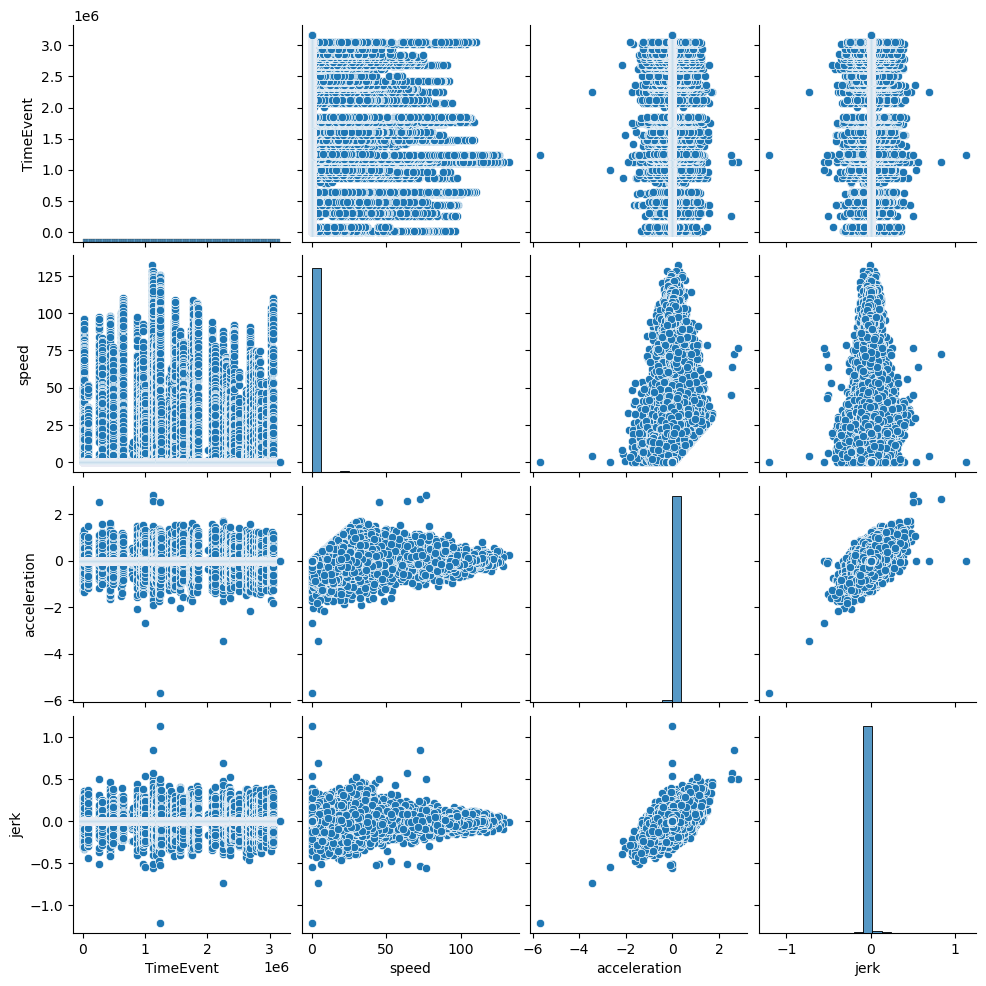

In [9]:
sns.pairplot(df)

# Temporal analysis

/home/urja/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Figure saved to driving_analysis.png


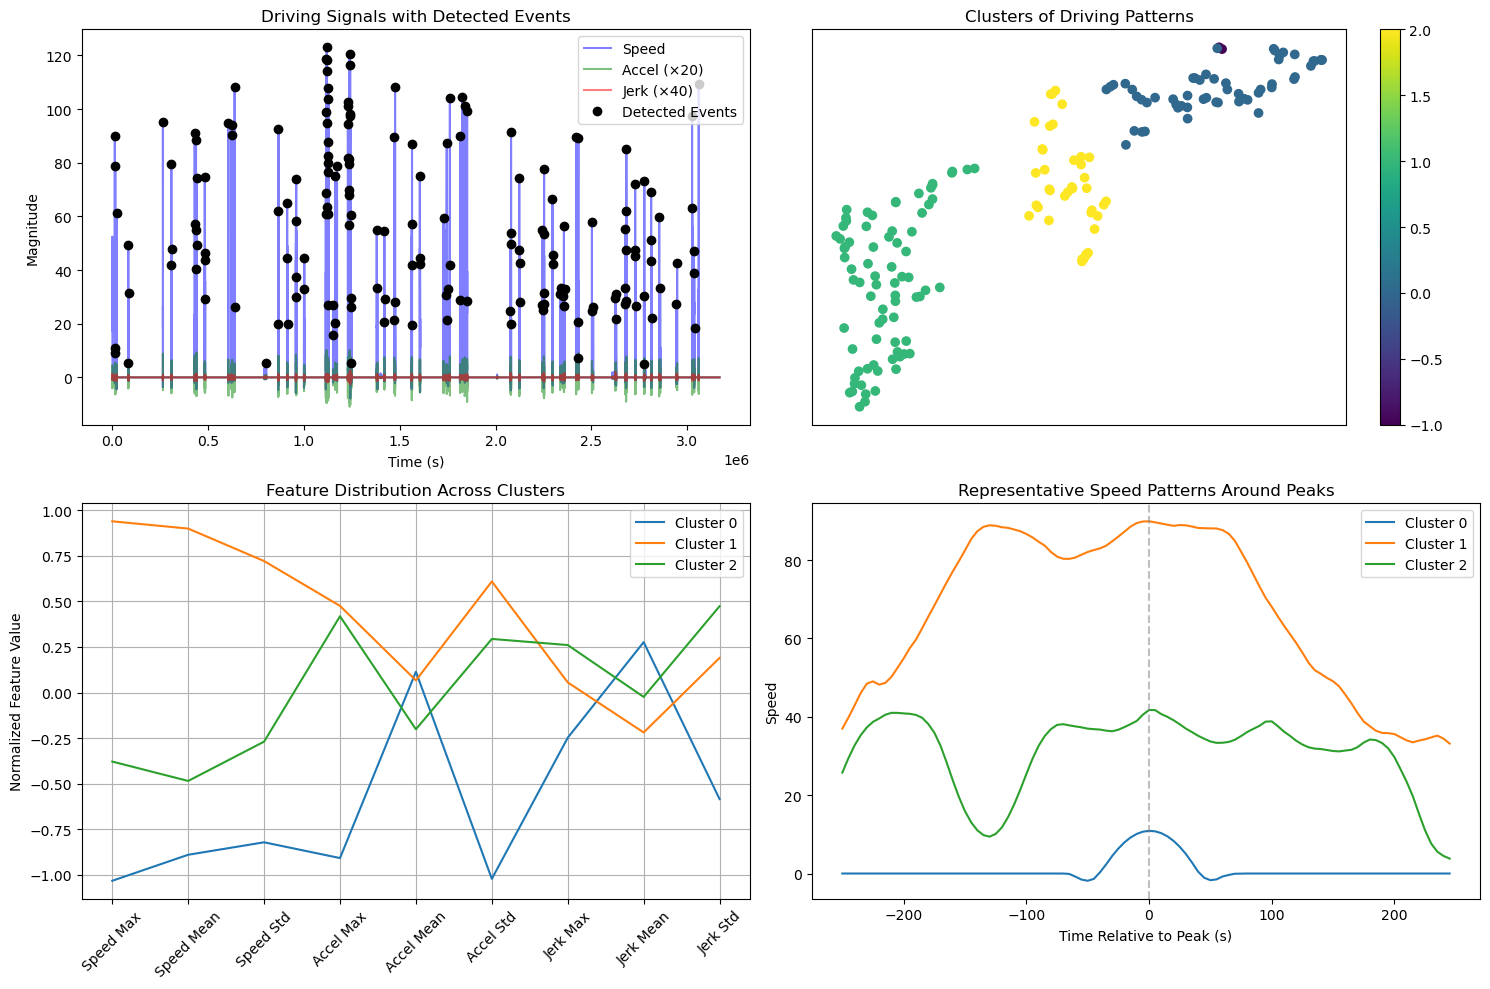

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import DBSCAN

def analyze_driving_patterns(df, save_path=None):
    """
    This function analyzes driving behavior using data on speed, acceleration, and jerk.
    It processes the data to detect key driving events, smooths the signals, extracts features
    around these events, scales the features, reduces dimensionality, and then clusters the
    driving patterns. Finally, it visualizes the results.
    
    Args:
        df (pd.DataFrame): Data containing time, speed, acceleration, and jerk data.
        save_path (str, optional): If provided, the plot will be saved to this file path.
        
    Returns:
        valid_peaks (np.array): Indices of the detected events.
        embedding (np.array): 2D representation of the data after dimensionality reduction.
        clusters (np.array): Cluster labels for each event.
        scalers (dict): Scalers used to normalize the features.
    """
    
    # Step 1: Smoothing the signals using Savitzky-Golay filter
    # This step helps reduce noise while keeping the important patterns intact
    window_size = 21  # This is the size of the smoothing window
    speed_smoothed = savgol_filter(df['speed'], window_size, 3)
    accel_smoothed = savgol_filter(df['acceleration'], window_size, 3)
    jerk_smoothed = savgol_filter(df['jerk'], window_size, 3)
    
    # Step 2: Detect peaks (events) in the smoothed speed data
    # Peaks represent key moments in the driving behavior (like quick accelerations or sharp turns)
    peak_indices, _ = find_peaks(speed_smoothed, 
                                  height=np.mean(speed_smoothed),  # Detect peaks above the average level
                                  distance=100,  # Ensure peaks are spaced out
                                  prominence=5)  # Ensure peaks are significantly taller than neighbors
    
    # Step 3: Extract features from the data around each peak
    segment_width = 50  # Number of time steps to consider around each detected peak
    speed_features = []
    accel_features = []
    jerk_features = []
    valid_peaks = []  # List to store peaks that have valid segments

    for peak in peak_indices:
        # Make sure the segment does not go out of bounds
        if peak - segment_width >= 0 and peak + segment_width < len(speed_smoothed):
            # Extract data segments centered around the peak
            speed_segment = speed_smoothed[peak - segment_width: peak + segment_width]
            accel_segment = accel_smoothed[peak - segment_width: peak + segment_width]
            jerk_segment = jerk_smoothed[peak - segment_width: peak + segment_width]
            
            # Calculate statistics (max, mean, std) for each signal segment
            speed_features.append([np.max(speed_segment), np.mean(speed_segment), np.std(speed_segment)])
            accel_features.append([np.max(accel_segment), np.mean(accel_segment), np.std(accel_segment)])
            jerk_features.append([np.max(jerk_segment), np.mean(jerk_segment), np.std(jerk_segment)])
            
            # Add the peak to the list of valid peaks
            valid_peaks.append(peak)

    # Step 4: Convert feature lists to numpy arrays for further processing
    speed_features = np.array(speed_features)
    accel_features = np.array(accel_features)
    jerk_features = np.array(jerk_features)
    valid_peaks = np.array(valid_peaks)

    # Step 5: Scale the features for fair comparison
    # We scale each type of feature (speed, acceleration, jerk) separately
    scalers = {
        'speed': StandardScaler(),
        'accel': StandardScaler(),
        'jerk': StandardScaler()
    }
    
    speed_scaled = scalers['speed'].fit_transform(speed_features)
    accel_scaled = scalers['accel'].fit_transform(accel_features)
    jerk_scaled = scalers['jerk'].fit_transform(jerk_features)
    
    # Combine all the scaled features into one dataset
    features_scaled = np.hstack([speed_scaled, accel_scaled, jerk_scaled])
    
    # Step 6: Reduce dimensionality using UMAP for visualization
    # UMAP reduces the high-dimensional data to 2D, which is easier to visualize
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.001, n_components=2, random_state=42)
    embedding = reducer.fit_transform(features_scaled)
    
    # Step 7: Cluster the driving patterns using DBSCAN
    # DBSCAN groups similar events together into clusters
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(embedding)
    
    # Step 8: Visualize the results with plots

    # Create a figure for multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Raw signals with detected peaks (events)
    axes[0, 0].plot(df['TimeEvent'], speed_smoothed, 'b-', label='Speed', alpha=0.5)
    axes[0, 0].plot(df['TimeEvent'], accel_smoothed * 20, 'g-', label='Accel (×20)', alpha=0.5)
    axes[0, 0].plot(df['TimeEvent'], jerk_smoothed * 40, 'r-', label='Jerk (×40)', alpha=0.5)
    axes[0, 0].plot(df['TimeEvent'][valid_peaks], speed_smoothed[valid_peaks], 'ko', label='Detected Events')
    axes[0, 0].set_title('Driving Signals with Detected Events')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].legend()

        # Plot 2: UMAP visualization (clustered events)
    scatter = axes[0, 1].scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='viridis')
    axes[0, 1].set_title('Clusters of Driving Patterns')
    axes[0, 1].set_xticks([])
    axes[0, 1].set_yticks([])
    
    # Fix: Use plt.colorbar() to add a colorbar to the plot
    plt.colorbar(scatter, ax=axes[0, 1])


    # Plot 3: Feature distributions across clusters
    feature_names = ['Speed Max', 'Speed Mean', 'Speed Std', 'Accel Max', 'Accel Mean', 'Accel Std', 'Jerk Max', 'Jerk Mean', 'Jerk Std']
    for cluster in np.unique(clusters[clusters >= 0]):
        cluster_features = features_scaled[clusters == cluster]
        axes[1, 0].plot(np.mean(cluster_features, axis=0), label=f'Cluster {cluster}')
    axes[1, 0].set_xticks(range(len(feature_names)))
    axes[1, 0].set_xticklabels(feature_names, rotation=45)
    axes[1, 0].set_title('Feature Distribution Across Clusters')
    axes[1, 0].set_ylabel('Normalized Feature Value')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot 4: Representative speed patterns for each cluster
    window_time = np.arange(-segment_width, segment_width) * 5
    for cluster in np.unique(clusters[clusters >= 0]):
        cluster_idx = np.where(clusters == cluster)[0][0]
        peak = valid_peaks[cluster_idx]
        axes[1, 1].plot(window_time, speed_smoothed[peak - segment_width:peak + segment_width], label=f'Cluster {cluster}')
    axes[1, 1].set_title('Representative Speed Patterns Around Peaks')
    axes[1, 1].set_xlabel('Time Relative to Peak (s)')
    axes[1, 1].set_ylabel('Speed')
    axes[1, 1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    axes[1, 1].legend()

    
    plt.tight_layout()

    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    
    plt.show()

    
    return valid_peaks, embedding, clusters, scalers


valid_peaks, embedding, clusters, scalers = analyze_driving_patterns(df, save_path='driving_analysis.png')


# Frequency-Domain Analysis

/home/urja/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_938232/3277967511.py:157: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Figure saved to fft_analysis.png


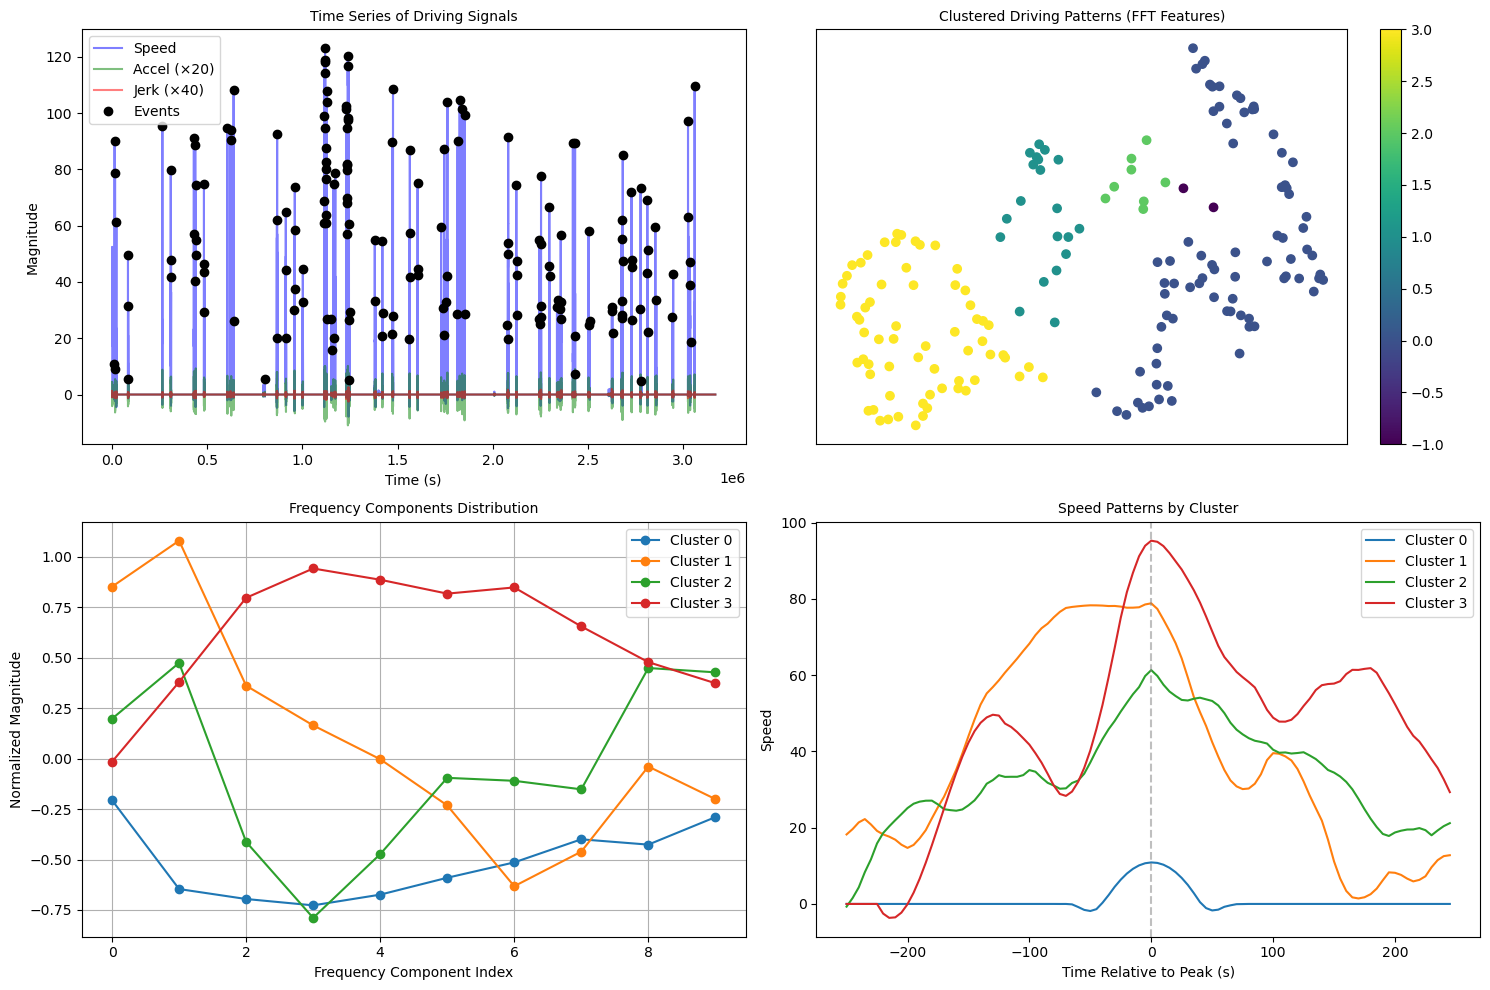

In [16]:
def extract_fft_features(signal, n_components=10):
    """
    Extract frequency domain features from a signal segment using FFT.

    Args:
        signal: Time series signal (1D array).
        n_components: Number of frequency components to retain after FFT.

    Returns:
        Array of FFT magnitudes for the first `n_components` frequencies.
    """
    # Apply a Hanning window to reduce spectral leakage before FFT
    window = np.hanning(len(signal))
    windowed_signal = signal * window

    # Compute the FFT and take the absolute value of the result (magnitude)
    fft_values = np.abs(fft(windowed_signal))

    # Only keep the unique half of the FFT result
    n_unique = len(fft_values) // 2
    fft_features = fft_values[1:min(n_components + 1, n_unique)]  # Skip the zero frequency and keep n_components

    # If there are fewer components, pad the result with zeros
    if len(fft_features) < n_components:
        fft_features = np.pad(fft_features, (0, n_components - len(fft_features)))

    return fft_features


def analyze_driving_patterns_fft(df, save_path=None):
    """
    Analyzes driving patterns using FFT-based feature extraction for speed, acceleration, and jerk.
    
    Args:
        df: DataFrame with columns ['TimeEvent', 'speed', 'acceleration', 'jerk']
        save_path: Optional path to save the figure
    
    Returns:
        valid_peaks, embedding, clusters, scalers, fft_features: Extracted data and analysis results
    """
    # Step 1: Preprocess signals by smoothing using Savitzky-Golay filter
    window_size = 21  # Length of the smoothing window (should be odd)
    speed_smooth = savgol_filter(df['speed'].values, window_size, 3)
    accel_smooth = savgol_filter(df['acceleration'].values, window_size, 3)
    jerk_smooth = savgol_filter(df['jerk'].values, window_size, 3)

    # Step 2: Identify peaks in the speed signal (used for segmentation)
    peaks, _ = find_peaks(speed_smooth, height=np.mean(speed_smooth), distance=100, prominence=5)

    # Step 3: Extract FFT features around each peak in the signal
    segment_width = 50  # Number of points around each peak to analyze
    n_fft_components = 10  # Number of frequency components to retain
    
    # Initialize empty lists to store FFT features for each signal type
    speed_fft_features = []
    accel_fft_features = []
    jerk_fft_features = []
    valid_peaks = []

    # Loop through each identified peak to extract the surrounding signal and its FFT features
    for peak in peaks:
        if peak - segment_width >= 0 and peak + segment_width < len(speed_smooth):
            # Extract signal segments centered around the peak
            speed_seg = speed_smooth[peak-segment_width:peak+segment_width]
            accel_seg = accel_smooth[peak-segment_width:peak+segment_width]
            jerk_seg = jerk_smooth[peak-segment_width:peak+segment_width]

            # Extract FFT features for each signal type
            speed_fft = extract_fft_features(speed_seg, n_fft_components)
            accel_fft = extract_fft_features(accel_seg, n_fft_components)
            jerk_fft = extract_fft_features(jerk_seg, n_fft_components)

            # Append the extracted features to the respective lists
            speed_fft_features.append(speed_fft)
            accel_fft_features.append(accel_fft)
            jerk_fft_features.append(jerk_fft)
            valid_peaks.append(peak)

    # Convert feature lists to numpy arrays for further processing
    speed_fft_features = np.array(speed_fft_features)
    accel_fft_features = np.array(accel_fft_features)
    jerk_fft_features = np.array(jerk_fft_features)
    valid_peaks = np.array(valid_peaks)

    # Step 4: Normalize the features using StandardScaler (to standardize across all components)
    scalers = {
        'speed': StandardScaler(),
        'accel': StandardScaler(),
        'jerk': StandardScaler()
    }

    speed_scaled = scalers['speed'].fit_transform(speed_fft_features)
    accel_scaled = scalers['accel'].fit_transform(accel_fft_features)
    jerk_scaled = scalers['jerk'].fit_transform(jerk_fft_features)

    # Combine all the scaled features into a single array
    features_scaled = np.hstack([speed_scaled, accel_scaled, jerk_scaled])

    # Step 5: Reduce dimensionality using UMAP (to visualize patterns in 2D)
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.01, n_components=2, random_state=42)
    embedding = reducer.fit_transform(features_scaled)

    # Step 6: Cluster the patterns using DBSCAN (Density-Based Spatial Clustering)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(embedding)

    # Step 7: Visualize the results with multiple plots

    # Create a figure with multiple subplots
    plt.figure(figsize=(15, 10))

    # Plot 1: Original signal traces with peaks
    plt.subplot(2, 2, 1)
    plt.plot(df['TimeEvent'], speed_smooth, 'b-', label='Speed', alpha=0.5)
    plt.plot(df['TimeEvent'], accel_smooth*20, 'g-', label='Accel (×20)', alpha=0.5)
    plt.plot(df['TimeEvent'], jerk_smooth*40, 'r-', label='Jerk (×40)', alpha=0.5)
    plt.plot(df['TimeEvent'][valid_peaks], speed_smooth[valid_peaks], 'ko', label='Events')
    plt.title('Time Series of Driving Signals', fontsize=10)
    plt.xlabel('Time (s)')
    plt.ylabel('Magnitude')
    plt.legend()

    # Plot 2: UMAP visualization with clustering
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='viridis')
    plt.title('Clustered Driving Patterns (FFT Features)', fontsize=10)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(scatter)

    # Plot 3: Frequency components distribution for each cluster
    plt.subplot(2, 2, 3)
    freq_components = np.arange(n_fft_components)
    for i, cluster in enumerate(np.unique(clusters[clusters >= 0])):
        cluster_mask = clusters == cluster
        avg_speed_fft = np.mean(speed_scaled[cluster_mask], axis=0)
        plt.plot(freq_components, avg_speed_fft, label=f'Cluster {cluster}', marker='o')
    plt.xlabel('Frequency Component Index')
    plt.ylabel('Normalized Magnitude')
    plt.title('Frequency Components Distribution', fontsize=10)
    plt.legend()
    plt.grid(True)

    # Plot 4: Speed patterns for each cluster
    plt.subplot(2, 2, 4)
    window_time = np.arange(-segment_width, segment_width) * 5
    for cluster in np.unique(clusters[clusters >= 0]):
        cluster_idx = np.where(clusters == cluster)[0][0]
        peak = valid_peaks[cluster_idx]
        plt.plot(window_time, speed_smooth[peak-segment_width:peak+segment_width], label=f'Cluster {cluster}')
    plt.title('Speed Patterns by Cluster', fontsize=10)
    plt.xlabel('Time Relative to Peak (s)')
    plt.ylabel('Speed')
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.legend()

    plt.tight_layout()

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    plt.show()

    return valid_peaks, embedding, clusters, scalers, {
        'speed_fft': speed_fft_features,
        'accel_fft': accel_fft_features,
        'jerk_fft': jerk_fft_features
    }

valid_peaks, embedding, clusters, scalers, fft_features = analyze_driving_patterns_fft(df, save_path='fft_analysis.png')
